# 희소행렬을 사용한 텍스트 문서 분류기
- **다중 클래스 텍스트 분류문제에 대한 여러 분류기의 측정시간, 성능값, 트레이드 오프 차이를 확인하는 것이 목적**
- BOW(bag of words) 접근 방식을 통한 문서 분류의 예
- 희소행렬을 효율적으로 처리하는 다양한 분류기들 사용예
    - **Tf-idf : weighted document-term sparse matrix : 가중 문서 용어 희소 행렬**
- 비지도 학습 방법을 통한 문서 분류 : k-means clustering


### 1. 데이터 임포트
- 20newsgroups 로드 함수 생성
- data에 포함 된 메타데이터
    - headers : 머리글
    - footers : 바닥글, 서명
    - quotes : 따옴표 글
- 이러한 메타데이터는 분류의 정답과 같은 역할을 하므로 제거해준다.
    - 분류를 너무 쉽게 만든다.
    - remove

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

In [2]:
categories = ["alt.atheism", "talk.religion.misc", "comp.graphics", "sci.space"]
categories

['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

In [3]:
def size_mb(docs) : 
    ## 1e6 : 백만
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

In [4]:
1e6

1000000.0

In [5]:
def load_dataset(verbose=False, remove=()) : 
    """Load and vectorize the 20 newsgroups dataset"""
    
    data_train = fetch_20newsgroups(
        subset="train", categories=categories, shuffle=True,
        random_state=42, remove=remove
    )
    
    data_test = fetch_20newsgroups(
        subset="test", categories=categories, shuffle=True,
        random_state=42, remove=remove
    )
    
    ## order of labels in "target_names" can be different from "categories"
    target_names = data_train.target_names
    
    ## split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target
    
    ## Extracting features from the training data using a sparse vectorizer
    ## 훈련용 희소행렬 생성 + 시간 측정
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0
    
    ## Extracting features form the test data using the same vetorizer
    ## 검증용 희소행렬 생성 + 시간측정
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0
    
    feature_names = vectorizer.get_feature_names_out()
    
    if verbose : 
        
        ## compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)
        
        print(f"{len(data_train.data)} documents - "
              f"{data_train_size_mb : .2f}MB (training set)")
        print(f"{len(data_test.data)} documents - "
              f"{data_test_size_mb : .2f}MB (test set)")
        print(f"{len(target_names)} categories")
        
        print(f"vectorizer training done in {duration_train : .3f}s "
              f"at {data_train_size_mb / duration_train : .3f}MB/s")
        print(f"n_samples : {X_train.shape[0]}, n_features : {X_train.shape[1]}")
        
        print(f"vectorizer testing done in {duration_test : .3f}s "
              f"at {data_test_size_mb / duration_test : .3f}MB/s")
        print(f"n_samples : {X_test.shape[0]}, n_features : {X_test.shape[1]}")
        
    return X_train, X_test, y_train, y_test, feature_names, target_names

### 2. BOW 문서 분류기 분석
- 2번 훈련
    - 메타 데이터 포함한 데이터
    - 메타 데이터를 포함하지 않은 데이터
- confusion matrix를 사용해서 검증 데이터 분류 오류를 분석
- 모델의 분류 기능을 수정

### 2-1. 메타 데이터 포함 데이터 임포트

In [6]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents -  3.98MB (training set)
1353 documents -  2.87MB (test set)
4 categories
vectorizer training done in  0.401s at  9.919MB/s
n_samples : 2034, n_features : 7831
vectorizer testing done in  0.270s at  10.622MB/s
n_samples : 1353, n_features : 7831


### 3. RidgeClassifier 분류기 사용
- 클래스별 평균 제곱 오차(mean squared error, mse)를 사용한 선형 분류 모델
- LogisticRegression과 달리 예측 조건부확률을 반환하지 않는다. (predict_proba)
- 학습 속도가 빠르다.
    - 조건부확률 계산이 생략되므로??

In [7]:
from sklearn.linear_model import RidgeClassifier

In [8]:
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf

RidgeClassifier(solver='sparse_cg', tol=0.01)

In [9]:
1e-2, 1e-1, 1e+0, 1e-0, 1e+1

(0.01, 0.1, 1.0, 1.0, 10.0)

In [10]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred.shape

(1353,)

In [11]:
pred

array([2, 1, 1, ..., 3, 1, 1], dtype=int64)

### 4. 분류 결과표를 시각화
- confusionmatrixdisplay : confusion matrix 를 시각화 할 수 있는 패키지
- **atheism 문서와 religion 문서가 서로 혼동되는 경향을 보인다.**
    - 주제를 보아도 문서의 의미가 겹칠 수 있다고 보인다.
- **sci.space 문서는 comp.graphics 문서로 잘 못 분류되는 것이 22개 있지만, comp.graphics 문서는 sci.space로 잘 못 분류되는 것이 4개로 훨씬 작다.**
- 이러한 비대칭성 문제를 해결하기 위해서는 잘 못 분류된 문서를 수동으로 검사해서 찾아야 한다.

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
%matplotlib inline

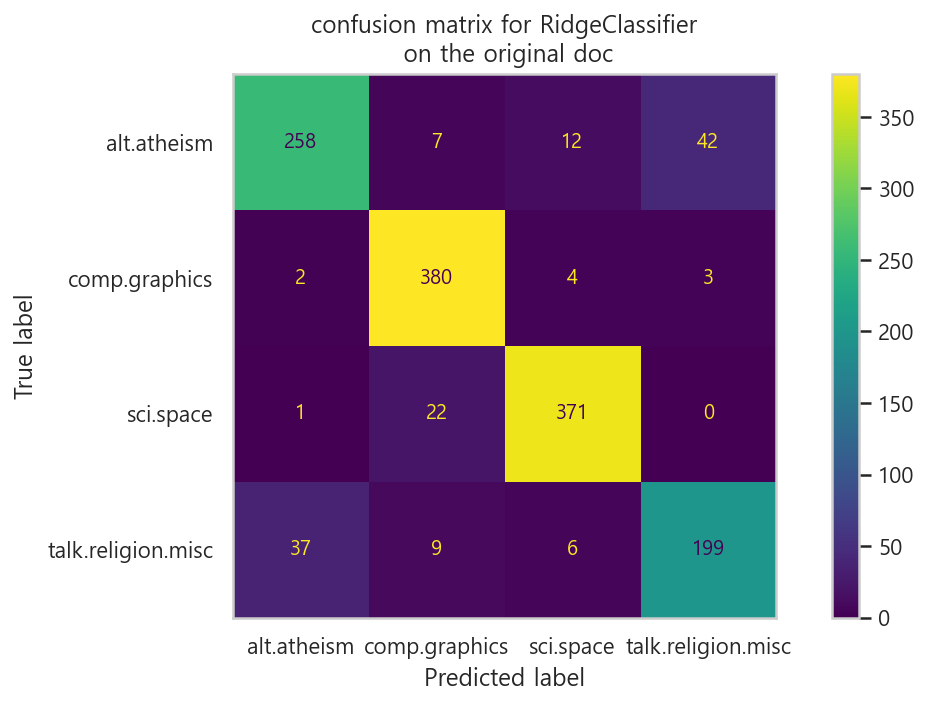

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(f"confusion matrix for {clf.__class__.__name__}\n on the original doc")
plt.grid(False); plt.show() ; 

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[258,   7,  12,  42],
       [  2, 380,   4,   3],
       [  1,  22, 371,   0],
       [ 37,   9,   6, 199]], dtype=int64)

In [16]:
from sklearn.metrics import classification_report

In [17]:
meta_in_data_model = classification_report(y_test, pred)
print(meta_in_data_model)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       319
           1       0.91      0.98      0.94       389
           2       0.94      0.94      0.94       394
           3       0.82      0.79      0.80       251

    accuracy                           0.89      1353
   macro avg       0.88      0.88      0.88      1353
weighted avg       0.89      0.89      0.89      1353



### 5. 분류 오류에 대한 단어 가중치 측정 그래프
- space와 grapics 문서의 분류 오류의 비대칭성이 생긴다.
    - space -> graphics : 22
    - graphics -> space : 4
- space 문서의 단어들이 graphics 문서에 더 많이 포함되어 있다는 것을 의미한다.    
    - **단어의 평균 특성 효과 words with average feature effects** 확인
- 예측력이 높은 단어들을 찾고 이 단어들이 각 클래스에서 어느정도의 가중치를 갖는지 비교
    - 예측력이 높은 단어는 각 클래스에서 평균 가중치 값이 가장 큰 것들

top 5 keywords per class : 
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


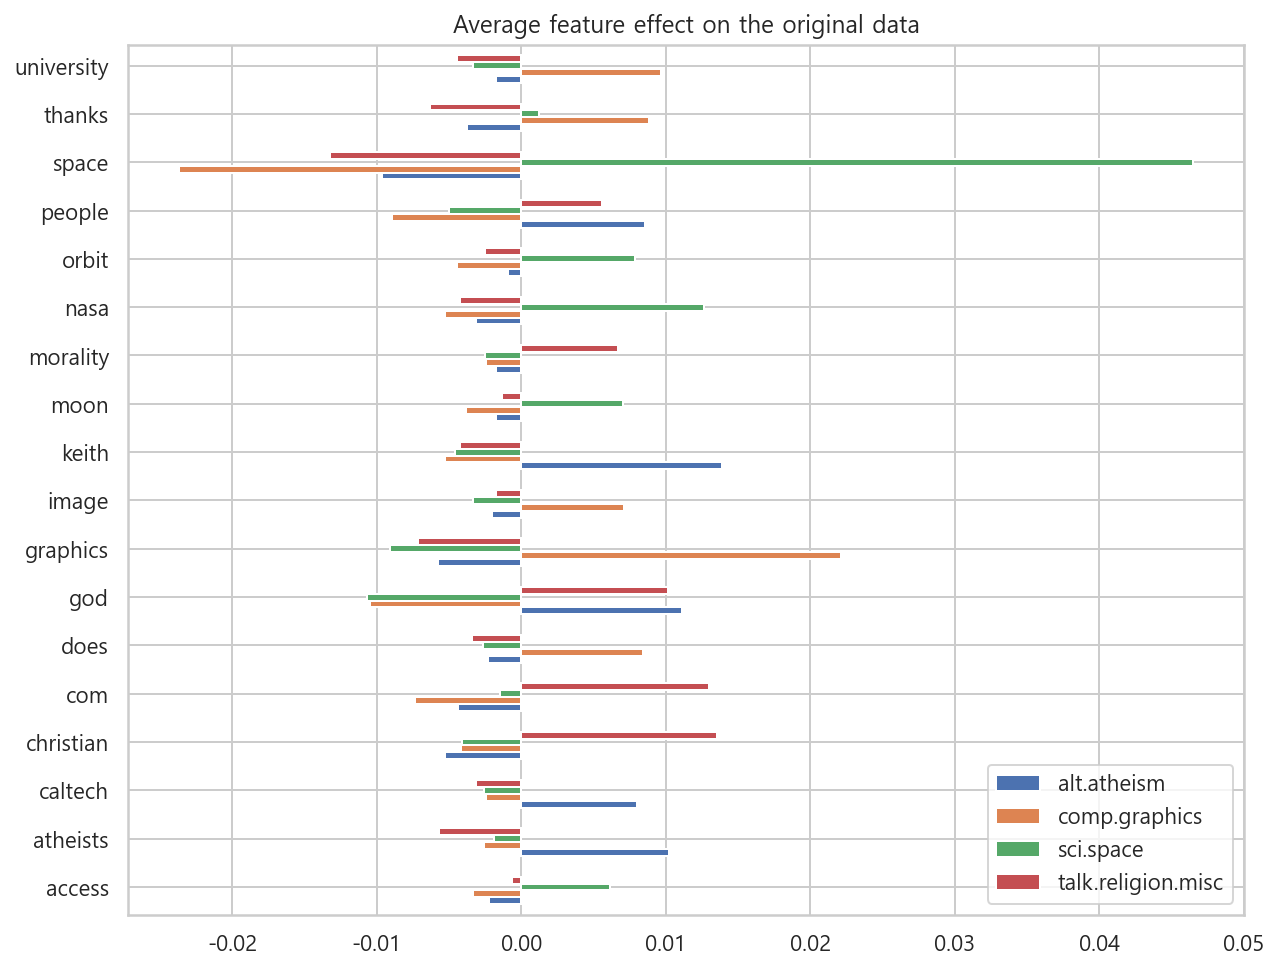

In [18]:
def plot_feature_effects() : 
    
    ## 단어의 출현 빈도수에 따른 가중치 계수
    ## clf : RidgeClassifier
    ## average_feature_effects = (4, 7831) * (7831,) = (4, 7831)
    ## 한 주제의 단어별 가중치 * 단어별 평균값 = 한 주제의 단어별 평균 가중치 
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    
    for i, label in enumerate(target_names) : 
        ## 각 주제별([i])로 작은값 순서로 정렬 후 인덱스 반환, 마지막 값이 큰 5개 선택, 순서뒤집기
        ## 여기서 인덱스는 말뭉치의 인덱스와 같음
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        ## 주제별 단어 평균 가중치가 높은 5개의 단어를 데이터 프레임으로 저장
        if i == 0 : 
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else : 
            ## 위에서 만든 데이터 프레임에 label 컬럼 만들고 top5 저장
            top[label] = feature_names[top5]
            ## 주제별 top index가 array로 연결 된다.
            top_indices = np.concatenate((top_indices, top5), axis=None)
    ## 인덱스 중복 제거
    top_indices = np.unique(top_indices)
    ## 중복 제거한 인덱스의 말뭉치
    predictive_words = feature_names[top_indices]
    
    ## 막대그래프로 나타내기
    ## 0~17까지 정수 배열 * 1.75
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names) : 
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label
        )
        
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size
        ]
    )
    
    ax.legend(loc="lower right")
    
    print("top 5 keywords per class : ")
    print(top)
    
    return ax

_ = plot_feature_effects().set_title("Average feature effect on the original data")

### 5-1. 코드 탐색

#### 분류기의 예측 계수
- 4개의 카테고리에 대한 각 문서별 가중치

In [19]:
clf.coef_

array([[-0.16530585,  0.11090095, -0.02065498, ..., -0.11544261,
        -0.08014153, -0.04356502],
       [-0.09059381, -0.36825998, -0.08242839, ..., -0.27116213,
        -0.13993439,  0.23255764],
       [ 0.30900523,  0.31498119,  0.15411618, ...,  0.49910056,
         0.33762185, -0.14364484],
       [-0.05425981, -0.057516  , -0.0505911 , ..., -0.12046141,
        -0.12266603, -0.0448499 ]])

In [20]:
clf.coef_.shape

(4, 7831)

#### tfidf를 통해 희소행렬로 변환된 학습 데이터의 평균값
- X_train은 (2034, 7831) 행렬
    - X_train.mean(axis=0) : 열별 평균값이므로 (1, 7831)이 된다.
- np.asarray() : 입력 된 값을 array로 변환해준다.
- ravel() : 2차원을 1차원 열벡터로 만들어 준다.
    - (7831,)

In [21]:
np.asarray(X_train.mean(axis=0))

array([[0.00221779, 0.00308012, 0.00033004, ..., 0.00433579, 0.0029596 ,
        0.00068472]])

In [22]:
np.asarray(X_train.mean(axis=0)).ravel()

array([0.00221779, 0.00308012, 0.00033004, ..., 0.00433579, 0.0029596 ,
       0.00068472])

In [23]:
avrege_fe = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
avrege_fe

array([[-3.66613932e-04,  3.41588090e-04, -6.81699928e-06, ...,
        -5.00535025e-04, -2.37186973e-04, -2.98299367e-05],
       [-2.00918199e-04, -1.13428442e-03, -2.72047798e-05, ...,
        -1.17570227e-03, -4.14149973e-04,  1.59237387e-04],
       [ 6.85309233e-04,  9.70179434e-04,  5.08647135e-05, ...,
         2.16399563e-03,  9.99225999e-04, -9.83568146e-05],
       [-1.20336959e-04, -1.77156101e-04, -1.66971547e-05, ...,
        -5.22295458e-04, -3.63042505e-04, -3.07097222e-05]])

In [24]:
avrege_fe.shape

(4, 7831)

In [25]:
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [26]:
feature_names[np.argsort(avrege_fe[0])[-5:][::-1]]

array(['keith', 'god', 'atheists', 'people', 'caltech'], dtype=object)

In [27]:
np.argsort(avrege_fe[0])[-5:][::-1]

array([3994, 3241,  883, 5256, 1316], dtype=int64)

In [28]:
for i, label in enumerate(target_names) : 
    print(i, label)
    top5 = np.argsort(avrege_fe[i])[-5:][::-1]
    print(top5)
    if i == 0 :
        top = pd.DataFrame(feature_names[top5], columns=[label])
        top_indices_all = top5
    else : 
        top[label] = feature_names[top5]
        top_indices_all = np.concatenate((top_indices_all, top5), axis=None)
        
top_indices = np.unique(top_indices_all)
predictive_words = feature_names[top_indices]

0 alt.atheism
[3994 3241  883 5256 1316]
1 comp.graphics
[3284 7382 7077 2395 3608]
2 sci.space
[6617 4786 5070 4687  467]
3 talk.religion.misc
[1502 1621 3241 4691 5256]


In [29]:
top

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,keith,graphics,space,christian
1,god,university,nasa,com
2,atheists,thanks,orbit,god
3,people,does,moon,morality
4,caltech,image,access,people


In [30]:
top_indices_all

array([3994, 3241,  883, 5256, 1316, 3284, 7382, 7077, 2395, 3608, 6617,
       4786, 5070, 4687,  467, 1502, 1621, 3241, 4691, 5256], dtype=int64)

In [31]:
top_indices

array([ 467,  883, 1316, 1502, 1621, 2395, 3241, 3284, 3608, 3994, 4687,
       4691, 4786, 5070, 5256, 6617, 7077, 7382], dtype=int64)

In [32]:
predictive_words

array(['access', 'atheists', 'caltech', 'christian', 'com', 'does', 'god',
       'graphics', 'image', 'keith', 'moon', 'morality', 'nasa', 'orbit',
       'people', 'space', 'thanks', 'university'], dtype=object)

### 6. 그래프 분석
- 예측력이 높은 단어들일 수록 하나의 클래스와 강하게 긍정적으로 연관되고, 다른 클래스와는 부정적으로 연관된다.
    - 특정 단어가 하나의 클래스에서 가중치 값이 크다.
- 두 개의 클래스에 긍정적으로 연관되어 있는 단어도 있다.
    - people, god
- caltech 단어는 일종의 메타데이터에서 온 단어로, antheism 클래스에 강한 연관성을 갖는다.
    - 메일 주소이다.
- 메타 데이터에 해당하는 머리글, 바닥글, 따옴표 글 등은 분류 모형에 불필요하다.    

In [33]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

for i, doc in enumerate(data_train.data) : 
    if "caltech" in doc : 
        print(doc[:1000])
        print("*" * 80)
        print("class : ", data_train.target_names[data_train.target[i]])
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

### 7. 메타 데이터 제외 데이터로 모델 훈련
- 클래스에 강하게 연관되어 있는 메타 데이터를 제외한 학습 데이터로 훈련
- 분류 결과표를 비교하면 메타 데이터 모델의 결과가 상대적으로 더 좋게 나온다는 것을 알 수 있다.
- 메타 데이터를 제외한 데이터를 사용한 경우 분류의 정확도(accuracy)는 떨어지지만, 정밀도(precision), 재현율(recall)은 커진다.

In [34]:
X_train, X_test, y_train, y_test, feature_names, target_names = \
load_dataset(remove=("headers", "footers", "quotes"))

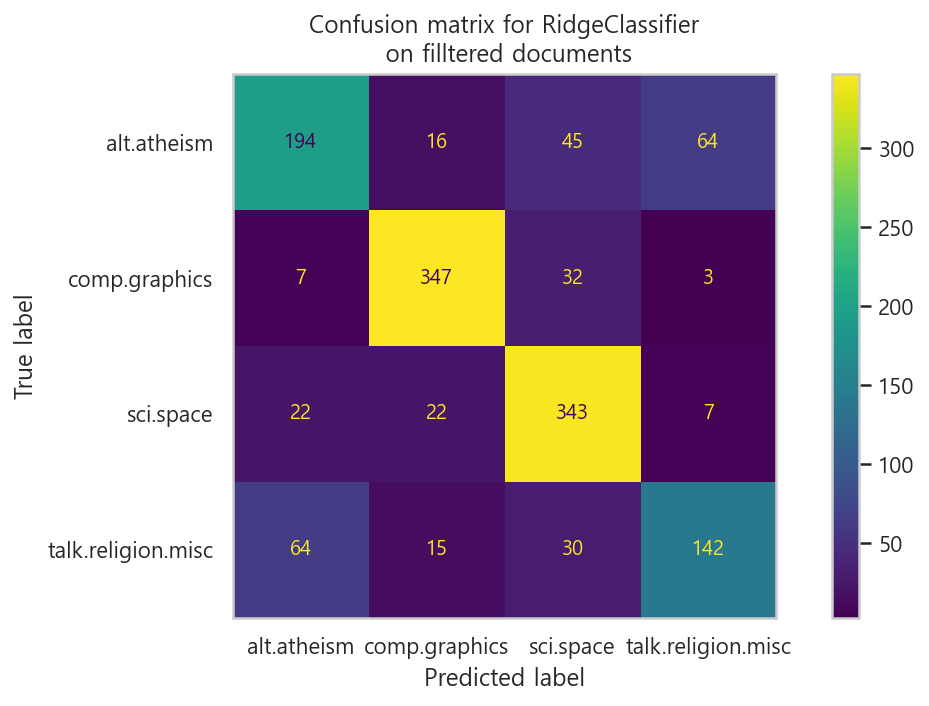

In [35]:
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(f"Confusion matrix for {clf.__class__.__name__}\n on filltered documents")
plt.grid(False) ; plt.show() ; 

top 5 keywords per class : 
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


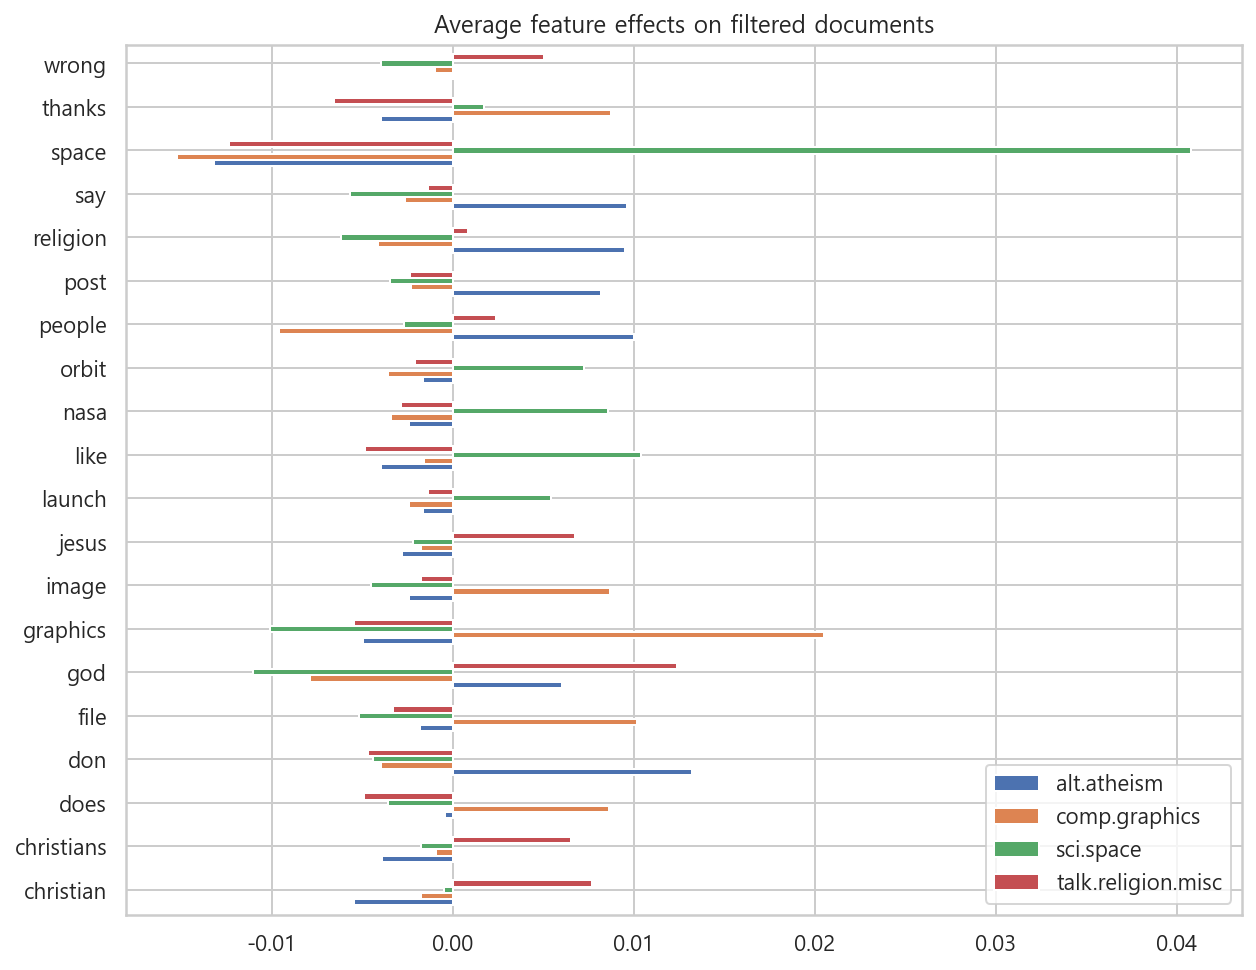

In [36]:
_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

In [37]:
from sklearn.metrics import classification_report

#### 메타 데이터 제외 

In [38]:
meta_not_in_data_model = classification_report(y_test, pred)
print(meta_not_in_data_model)

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       319
           1       0.87      0.89      0.88       389
           2       0.76      0.87      0.81       394
           3       0.66      0.57      0.61       251

    accuracy                           0.76      1353
   macro avg       0.74      0.73      0.74      1353
weighted avg       0.75      0.76      0.75      1353



#### 메타 데이터 포함

In [39]:
print(meta_in_data_model)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       319
           1       0.91      0.98      0.94       389
           2       0.94      0.94      0.94       394
           3       0.82      0.79      0.80       251

    accuracy                           0.89      1353
   macro avg       0.88      0.88      0.88      1353
weighted avg       0.89      0.89      0.89      1353



In [40]:
clf

RidgeClassifier(solver='sparse_cg', tol=0.01)

In [41]:
clf.__class__.__name__

'RidgeClassifier'

### 8. 분류 모델 측정 함수
- accuracy, computing performance(speed), training time, testing time
- density 클래스 : 희소 행렬의 밀도 계산
- hasattr : 개체에 지정된 이름의 속성이 있는지 확인

In [42]:
from sklearn.utils.extmath import density
from sklearn import metrics

In [43]:
def benchmark(clf, custom_name=False) : 
    print("_" * 80)
    print("Training : ")
    print(clf)
    
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time : {train_time : .3}s")
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time : {test_time : .3}s")
    
    ## sklearn의 metrics 패키지의 accuracy_score 클래스를 import 없이 직접 사용할 수 있다.
    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy : {score : .3}")
    
    if hasattr(clf, "coef_") : 
        print(f"dimencionality : {clf.coef_.shape[1]}")
        print(f"density : {density(clf.coef_)}")
        
    print()
    if custom_name : 
        clf_descr = str(custom_name)
    else : 
        clf_descr = clf.__class__.__name__
        
    return clf_descr, score, train_time, test_time

### 9. 분류 모델 생성 및 학습
- 여러 분류 모델의 측정시간, 정확도(성능), 트레이드 오프(threshold 값의 변화)를 비교

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

In [45]:
results = []

for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "KNN"),
    (RandomForestClassifier(), "Random Forest"),
    ## L2 penalty linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    
    ##(SGDClassifier(loss="log_loss", alpha=1e-4, n_iter_no_change=3,
    ##               early_stopping=True), "log-loss SGD"),
    
    ## NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    ## sparse naive bayes classifier
    (ComplementNB(alpha=0.1), "Complement Naive Bayes")
) : 
    
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training : 
LogisticRegression(C=5, max_iter=1000)
train time :  0.527s
test time :  0.001s
accuracy :  0.773
dimencionality : 5316
density : 1.0

Ridge Classifier
________________________________________________________________________________
Training : 
RidgeClassifier(solver='sparse_cg')
train time :  0.026s
test time :  0.001s
accuracy :  0.76
dimencionality : 5316
density : 1.0

KNN
________________________________________________________________________________
Training : 
KNeighborsClassifier(n_neighbors=100)
train time :  0.00202s
test time :  0.155s
accuracy :  0.752

Random Forest
________________________________________________________________________________
Training : 
RandomForestClassifier()
train time :  1.06s
test time :  0.056s
accuracy :  0.698

Linear SVC
________________________________________________________________________________
Training : 
LinearSVC(C=0.1, du

In [46]:
results

[('Logistic Regression',
  0.7730968218773097,
  0.5265343189239502,
  0.0010018348693847656),
 ('Ridge Classifier',
  0.7597930524759793,
  0.026001930236816406,
  0.0009996891021728516),
 ('KNN', 0.7524020694752402, 0.002019166946411133, 0.15497803688049316),
 ('Random Forest', 0.6977087952697709, 1.05800461769104, 0.055999755859375),
 ('Linear SVC', 0.7516629711751663, 0.02735304832458496, 0.00099945068359375),
 ('NearestCentroid',
  0.7479674796747967,
  0.0039997100830078125,
  0.0019991397857666016),
 ('Complement Naive Bayes',
  0.779009608277901,
  0.0020122528076171875,
  0.0009913444519042969)]

### 10. 분류 모델 결과 비교 그래프
- scatter plot을 사용하여 모델별 정확도와 훈련, 테스트 시간의 균형을 나타냄

In [47]:
indices = np.arange(len(results))
indices

array([0, 1, 2, 3, 4, 5, 6])

### 10-1. 각 모델의 결과값에서 특정 인덱스별로 저장
- benchmark 함수의 결과값에서 각 순번의 데이터끼리 뭉쳐서 저장
    - 0 : 모델의 이름
    - 1 : 정확도
    - 2 : train time
    - 3 : test time
- 이중 리스트컴프리헨션 사용
    - **반복된 tuple 값에서 같은 인덱스의 값을 한 곳에 뭉치는 방법으로 좋다.**
    - [("hong", "1"), ("kim", "2"), ("june", "3")]
    - zip 을 써서 풀어도 될 것 같다.

In [48]:
results2 = [[x[i] for x in results] for i in range(4)]
results2

[['Logistic Regression',
  'Ridge Classifier',
  'KNN',
  'Random Forest',
  'Linear SVC',
  'NearestCentroid',
  'Complement Naive Bayes'],
 [0.7730968218773097,
  0.7597930524759793,
  0.7524020694752402,
  0.6977087952697709,
  0.7516629711751663,
  0.7479674796747967,
  0.779009608277901],
 [0.5265343189239502,
  0.026001930236816406,
  0.002019166946411133,
  1.05800461769104,
  0.02735304832458496,
  0.0039997100830078125,
  0.0020122528076171875],
 [0.0010018348693847656,
  0.0009996891021728516,
  0.15497803688049316,
  0.055999755859375,
  0.00099945068359375,
  0.0019991397857666016,
  0.0009913444519042969]]

### 10-2. 결과값 변수 저장

In [49]:
clf_names, score, training_time, test_time = results2
training_time = np.array(training_time)
test_time = np.array(test_time)

In [50]:
clf_names

['Logistic Regression',
 'Ridge Classifier',
 'KNN',
 'Random Forest',
 'Linear SVC',
 'NearestCentroid',
 'Complement Naive Bayes']

In [51]:
score

[0.7730968218773097,
 0.7597930524759793,
 0.7524020694752402,
 0.6977087952697709,
 0.7516629711751663,
 0.7479674796747967,
 0.779009608277901]

In [52]:
training_time

array([0.52653432, 0.02600193, 0.00201917, 1.05800462, 0.02735305,
       0.00399971, 0.00201225])

In [74]:
np.log10(training_time)

array([-0.27857332, -1.58499441, -2.69482777,  0.02448756, -1.56299427,
       -2.39797149, -2.69631746])

In [53]:
test_time

array([0.00100183, 0.00099969, 0.15497804, 0.05599976, 0.00099945,
       0.00199914, 0.00099134])

### 10-3. scatter plot 
- 10,000 차원 이상일 때 선형 모델이 더 적합한 경우가 많다.
    - 랜덤포레스트는 성능이 떨어지고 측정시간도 길다.
    - ComeplementNB는 성능도 좋고, 측정시간도 짧다.
- 선형모델의 훈련 속도와 정확도
    - 최적화 하는 손실 함수의 선택
    - 정규화 종류에 따라서 달라진다.
    - loss는 같은데, solver나 정규화(regularization configuration)가 다르면 속도와 성능이 달라질 수 있다.
    - 선형 모델 3가지의 정확도가 거의 같은 것을 알 수 있다.
- knn이 시간이 가장 길고, 상대적으로 정확도가 낮다. 
    - 샘플 데이터와 문서 사이의 쌍별 거리를 계산해야하기 때문이다.
    - 차원의 저주 문제로 인해 텍스트 분류에서 비교적 정확도가 높은 knn 모델의 기능을 손상시킨다.

In [54]:
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False

In [97]:
clf_names_2 = ['LR',
 'Ridge Clf',
 'KNN',
 'RF Clf',
 'Linear SVC',
 'NC Cluster',
 'Complement NB']

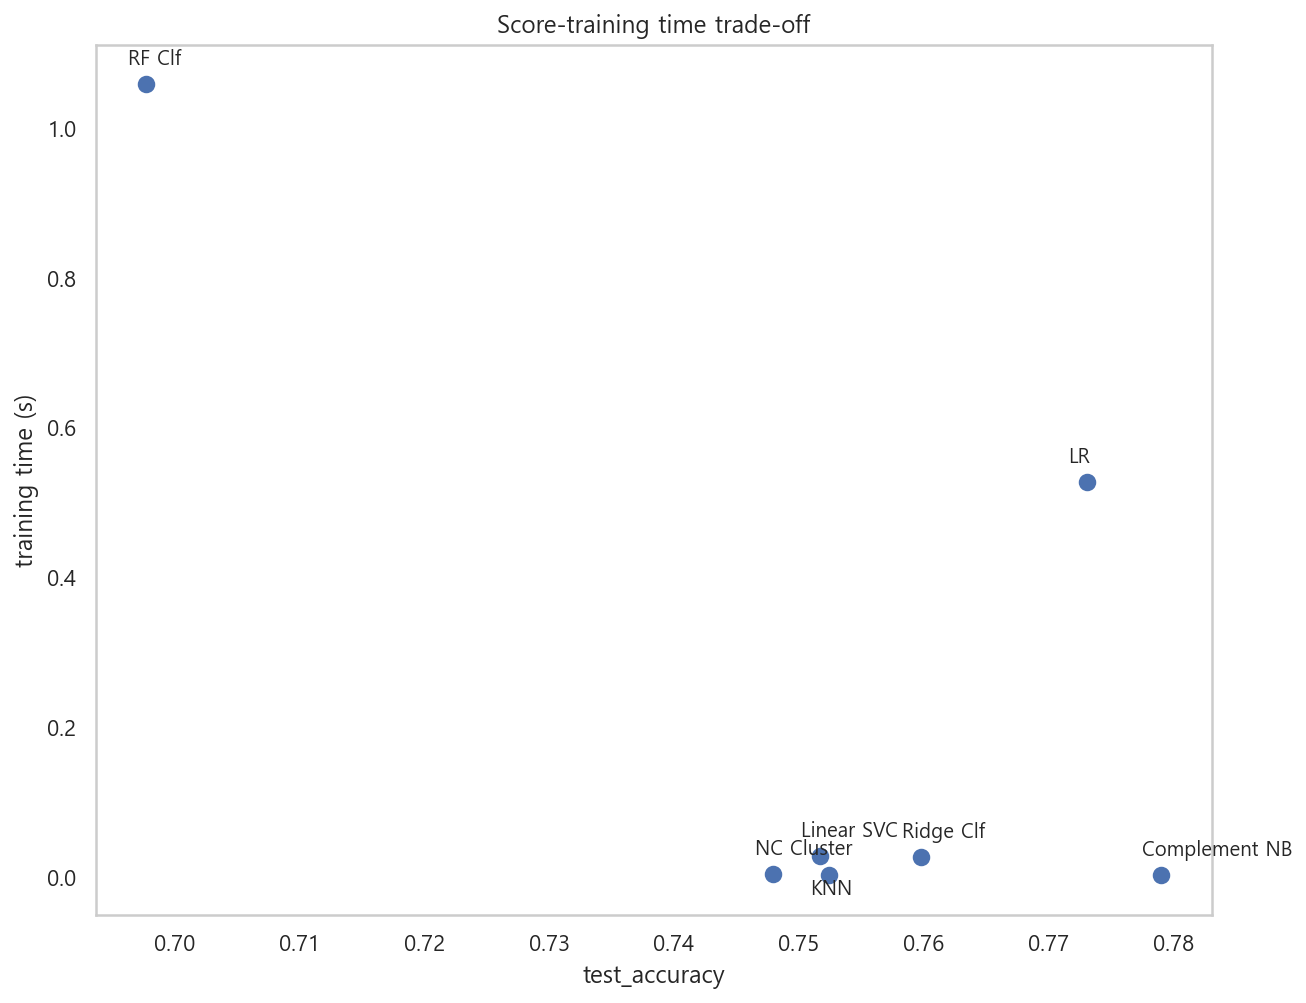

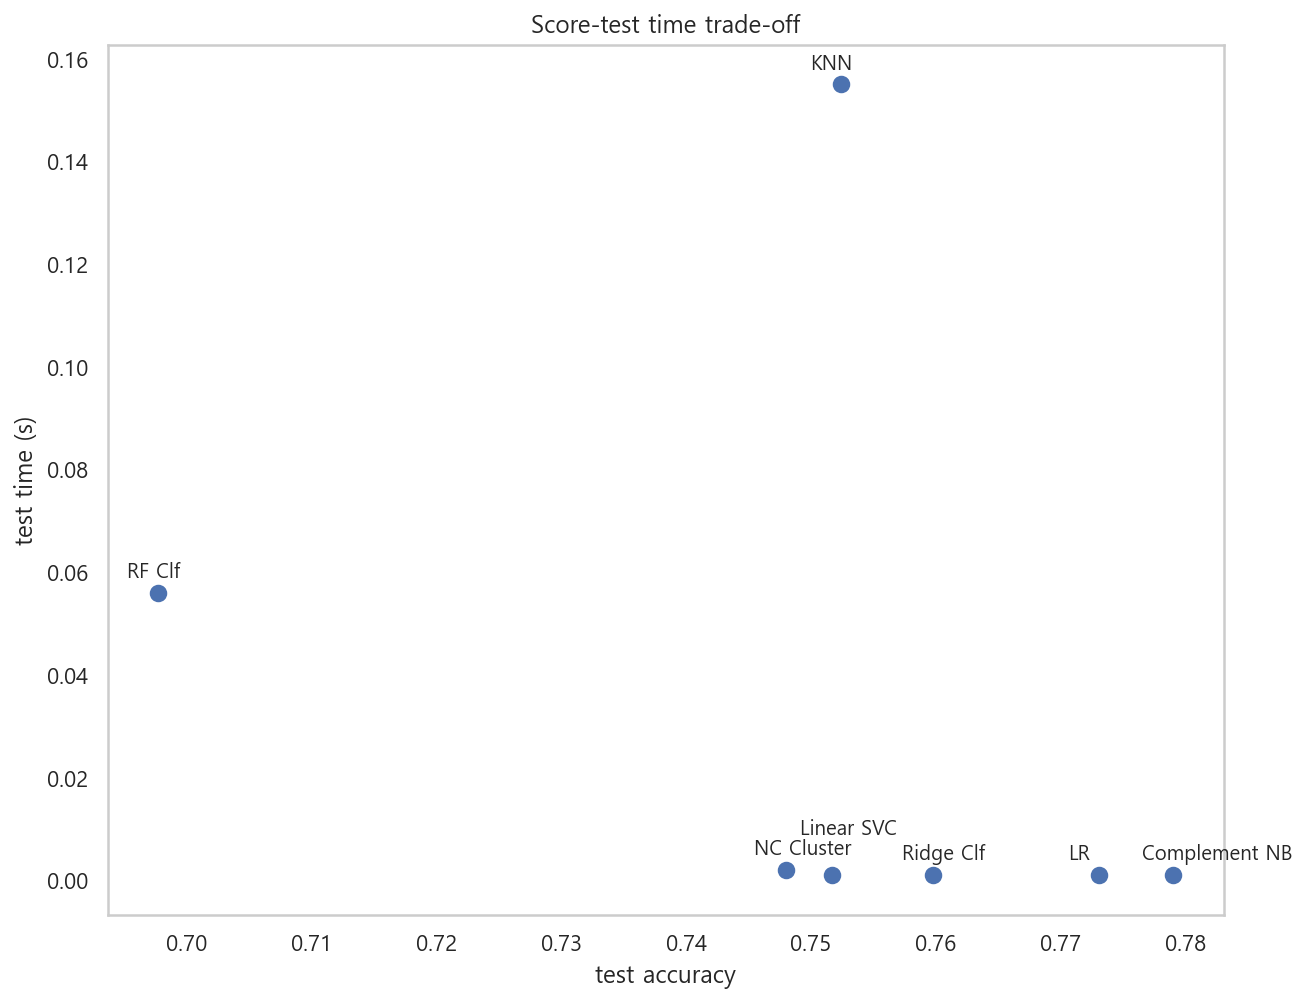

In [115]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)

#ax1.set_yscale("log")
#ax1.set_yticks([0, 0.5, 1.0])
ax1.set_xlabel("test_accuracy")
ax1.set_ylabel("training time (s)")
ax1.set_title("Score-training time trade-off")

plt.grid(False) ; 

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    #yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)"
)
#ax2.set_yticks([0, 0.5, 1.0])

for i, txt in enumerate(clf_names_2) :
    if txt != "KNN" : 
        ax1.annotate(txt, (score[i]-0.0015, training_time[i]+0.026))
    else : 
        ax1.annotate(txt, (score[i]-0.0015, training_time[i]-0.026))
    if txt != "Linear SVC" :
        ax2.annotate(txt, (score[i]-0.0025, test_time[i]+0.003))
    else :
        ax2.annotate(txt, (score[i]-0.0025, test_time[i]+0.008))
    
plt.grid(False) ; plt.show() ;     